In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import os
import sys
import inspect
import glob

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [4]:
from scripts.plot_timed_cuda import *

In [5]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.dpi'] = 200

In [6]:
timing_file_cuda = "../kiev0/results/cuda/out/2021-12-06T18:50:57,497711605+0900.out" # nvcc
last_timing_files = [
    "../results/openmp/out/2022-01-12T18:09:43,578693563+09:00.out", #openmp
    "../results/cuda/out/2022-01-12T14:16:00,174019558+09:00.out", # cpucuda
    "../results/cuda/out/2022-01-12T11:51:30,811930753+09:00.out", # polygeist
]

In [7]:
def get_last_n_files(last, n):
    dir = os.path.dirname(last)
    files = glob.glob(dir + '/*')
    files.sort()
    for i, file in enumerate(files):
        if file == last:
            last_i = i;
    return files[last_i - n + 1: last_i + 1]

In [8]:
def find_min_summaries(summaries):
    measurements = list(summaries[0][1].keys())
    #print(measurements)
    min_summaries = {}
    for measurement in measurements:
        min_id = np.argmin([summary[1][measurement] for summary in summaries])
        min_summaries[measurement] = {
            'omp_thread_num': summaries[min_id][0]['omp_thread_num'],
            'time': summaries[min_id][1][measurement],
        }
    max_threads = max([summary[0]['omp_thread_num'] for summary in summaries])
    return (
        {
            'hostname': summaries[0][0]['hostname'],
            'compilername': summaries[0][0]['compilername'],
            'omp_max_thread_num': max([int(summary[0]['omp_thread_num']) for summary in summaries])
        },
        min_summaries
    )

In [9]:
# files for 1 .. 64 threads
timing_filess = [get_last_n_files(last, 64) for last in last_timing_files]
timing_summariess = [[create_file_timing_data_summary(read_timing_data_from_file(f)) for f in timing_files] for timing_files in timing_filess]
min_summaries = [find_min_summaries(timing_summaries) for timing_summaries in timing_summariess]

In [10]:
timing_summaries = [create_file_timing_data_summary(read_timing_data_from_file(timing_file_cuda))] + min_summaries

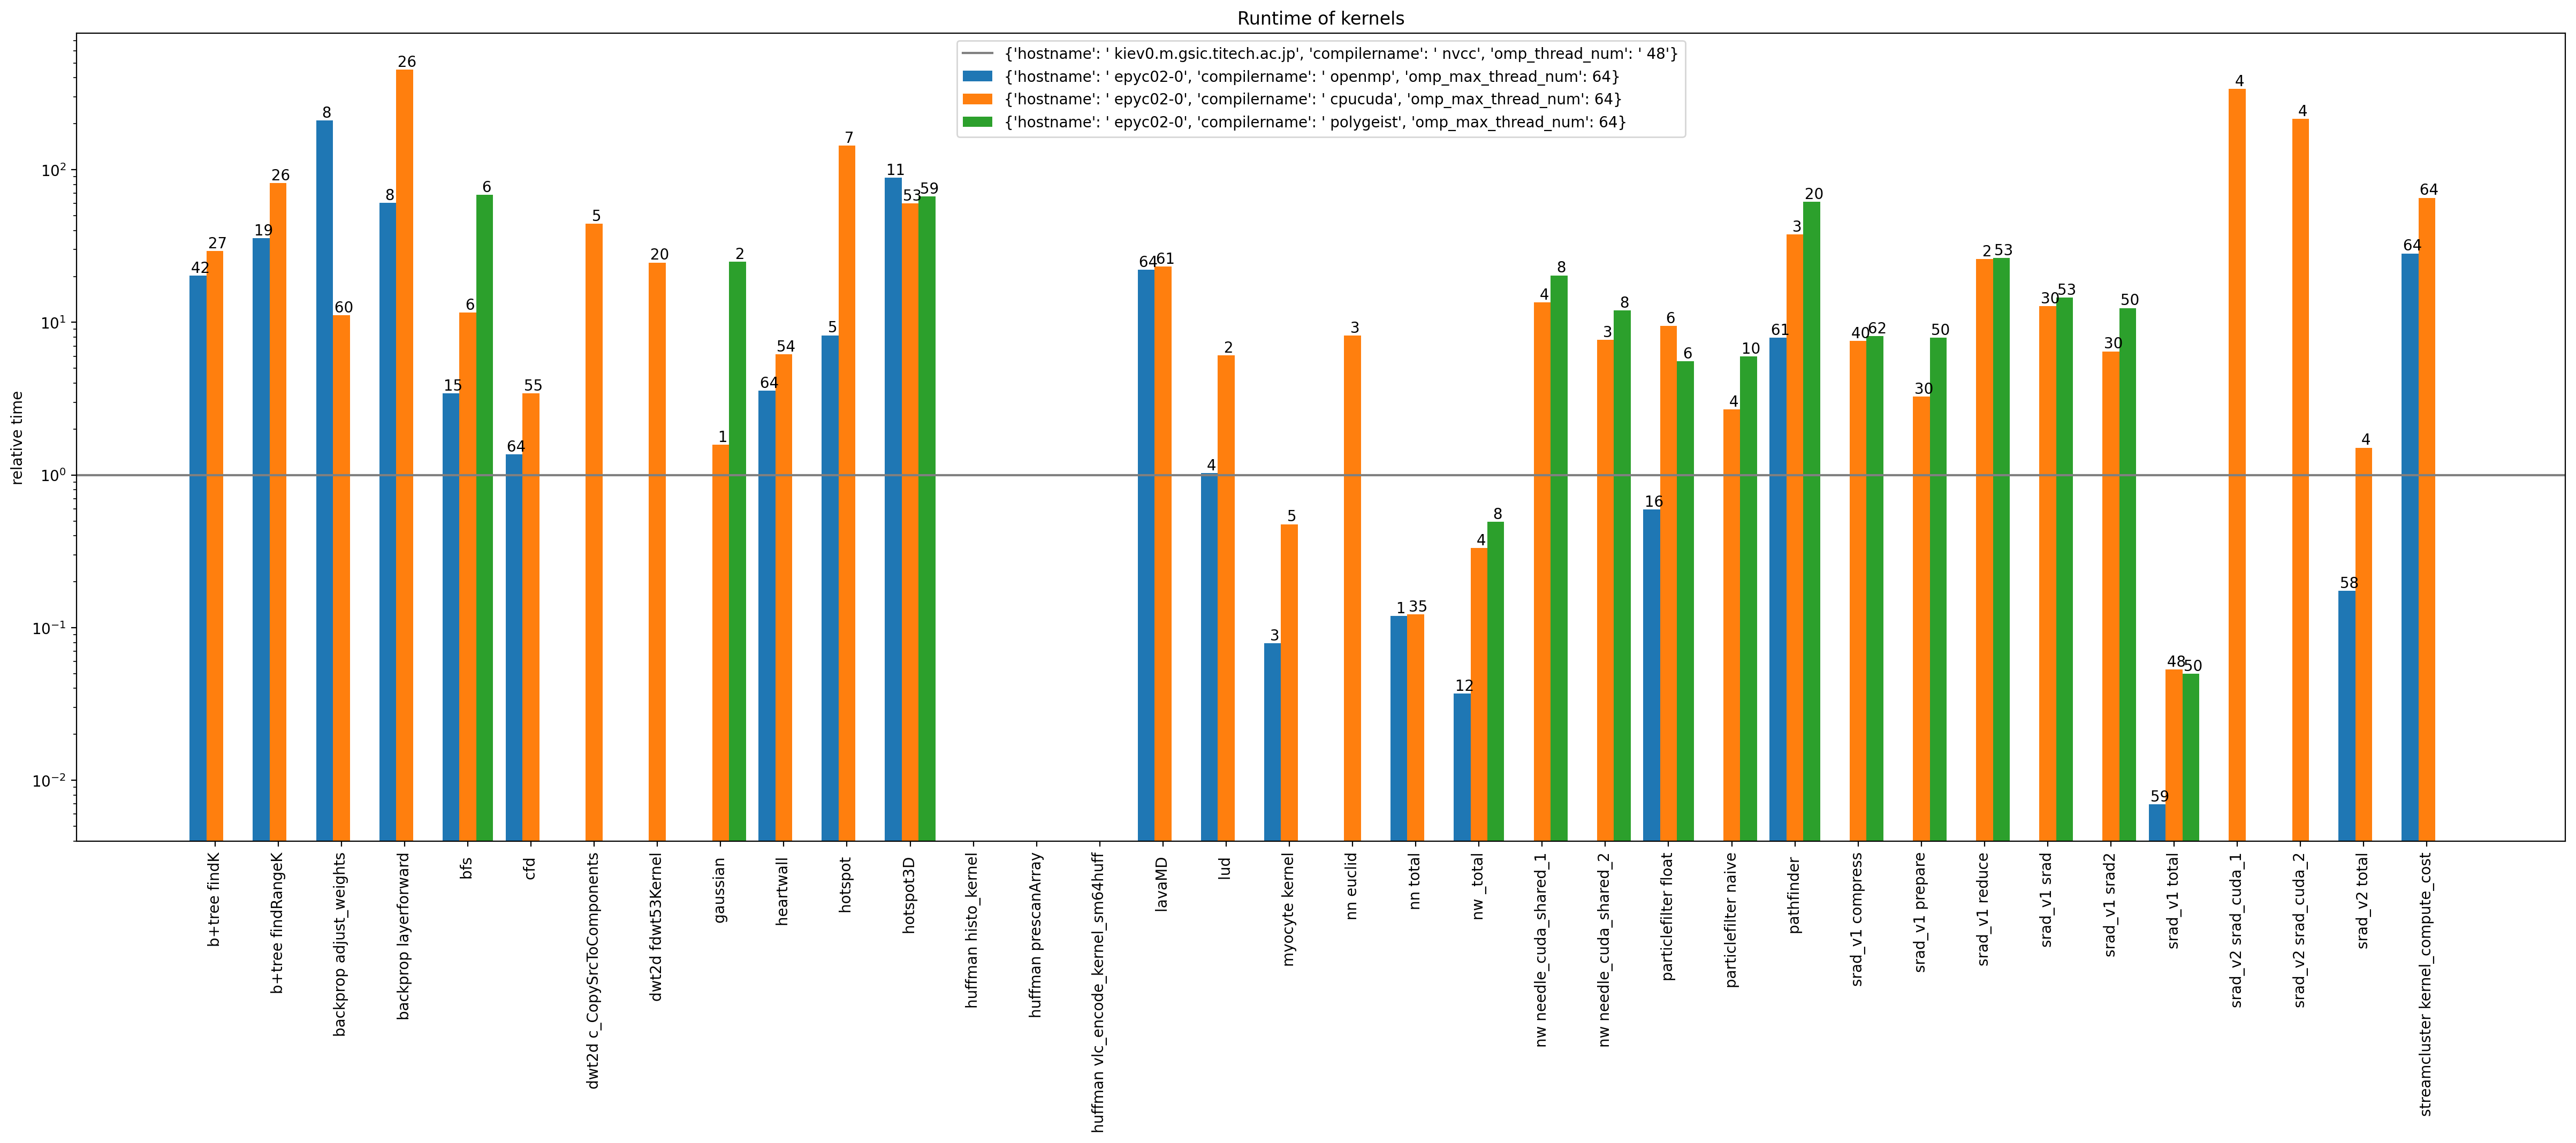

In [11]:
plot_min_summaries(timing_summaries)

In [30]:
def performance_difference(s1, s2):
    kernels = set(s1[1].keys()).intersection(set(s2[1].keys()))
    def get_time(v):
        return v['time'] if type(v) == dict else v 
    def get_average_runtime(s):
        return sum([get_time(v) for k, v in s[1].items() if k in kernels]) / len(kernels)
    a1 = get_average_runtime(s1)
    a2 = get_average_runtime(s2)
    print('average times')
    print('{}: {}'.format(s1[0], a1))
    print('{}: {}'.format(s2[0], a2))
    print('factor of {}'.format(a1 / a2 if a1 > a2 else a2 / a1))

performance_difference(timing_summaries[1], timing_summaries[2])

average times
{'hostname': ' epyc02-0', 'compilername': ' openmp', 'omp_max_thread_num': 64}: 0.41680725660597784
{'hostname': ' epyc02-0', 'compilername': ' cpucuda', 'omp_max_thread_num': 64}: 1.04006013796721
factor of 2.495302376538071
